#TEXT MINING - Gadda Alberto (824029), Guerini Rocco Paolo (826236)


## Original dataset source: https://www.kaggle.com/datasets/nitishabharathi/email-spam-dataset
## Alternative folder: https://drive.google.com/drive/folders/1rvZufHlG9KzmiZvtrWHuB_XnalDxXVC1

In [ ]:
%%capture

!pip install Unidecode
!pip install pycld2 
!pip install googletrans==3.1.0a0
!pip install python-Levenshtein
!pip install tmtoolkit
!pip install -q pyLDAvis==2.1.2


from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle as pk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from Levenshtein import distance as lev
from googletrans import Translator
import pycld2 as cld2
import pandas as pd 
import time
import numpy as np
from google.colab import drive
from shutil import copyfile
import matplotlib.pyplot as plt
import nltk
import string
import re 
from textblob import TextBlob
from bs4 import BeautifulSoup 
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from unidecode import unidecode
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import tmtoolkit
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.stem import WordNetLemmatizer
import warnings

pyLDAvis.enable_notebook()
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
drive.mount('/content/gdrive')

def warn(*args, **kwargs):
    pass
warnings.warn = warn

plt.rcParams['figure.figsize'] = [15,5] # width, height

In [ ]:
copyfile('gdrive/MyDrive/Text Mining/completeSpamAssassin.csv', 'completeSpamAssassin.csv' )
copyfile('gdrive/MyDrive/Text Mining/enronSpamSubset.csv', 'enronSpamSubset.csv')
copyfile('gdrive/MyDrive/Text Mining/lingSpam.csv', 'lingSpam.csv')

# **PREPROCESSING**

In [ ]:
assassin = pd.read_csv('completeSpamAssassin.csv')
enron = pd.read_csv('enronSpamSubset.csv')
ling = pd.read_csv('lingSpam.csv')

In [ ]:
print(f" spam in assassin: \t{round(len(assassin[assassin['Label']==1])/len(assassin),2)*100}%  on {len(assassin)}\t document")
print(f" spam in enron: \t{round(len(enron[enron['Label']==1])/len(enron),2)*100}%  on {len(enron)}\t document")
print(f" spam in ling: \t\t{round(len(ling[ling['Label']==1])/len(ling),2)*100}%  on {len(ling)}\t document")

 spam in assassin: 	31.0%  on 6046	 document
 spam in enron: 	50.0%  on 10000	 document
 spam in ling: 		17.0%  on 2605	 document


In [ ]:
assassin = assassin[['Body','Label']]
enron = enron[['Body','Label']]
ling = ling[['Body','Label']]

assassin['dataset'] = 'assassin'
enron['dataset'] = 'enron'
ling['dataset'] = 'ling'

In [ ]:
data = pd.concat([assassin, enron, ling])
data.reset_index(inplace=True, drop=True)

In [ ]:
# Remove "Subject" at the beginning of the mail
def remove_subject(x):
  x=str(x)
  if x[0:9] =='Subject: ':
    x = x[9:]
  return x

data['Body'] = data['Body'].apply(lambda x: remove_subject(x))

TRAIN TEST SPLIT

In [ ]:
train, test = train_test_split(data, test_size=0.25, stratify=data['Label'], random_state=123)
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

In [ ]:
sum(train['Body'].isnull())

0

In [ ]:
train['dup'] = train.duplicated(subset=['Body'])

In [ ]:
train[train['dup']==True]

,Body,Label,dataset,dup
11,empty,1,assassin,True
131,empty,1,assassin,True
133,empty,0,assassin,True
152,empty,1,assassin,True
182,empty,1,assassin,True
...,...,...,...,...
13897,"re : ercs - you are wrong , they are not just ...",0,enron,True
13900,empty,0,assassin,True
13927,empty,0,assassin,True
13943,"\n r 3 mov 3\n lisa montgomery , 36 , of melve...",1,enron,True


In [ ]:
train[train['Body']=='empty']

,Body,Label,dataset,dup
0,empty,1,assassin,False
11,empty,1,assassin,True
131,empty,1,assassin,True
133,empty,0,assassin,True
152,empty,1,assassin,True
...,...,...,...,...
13884,empty,0,assassin,True
13888,empty,1,assassin,True
13900,empty,0,assassin,True
13927,empty,0,assassin,True


In [ ]:
train.drop(columns=['dup'], inplace=True)
len(train)

13988

In [ ]:
train.drop_duplicates(subset=['Body'], keep='first', inplace=True)
train.reset_index(inplace=True, drop=True)

In [ ]:
len(train)

13253

In [ ]:
print(f"number of documents containing SPAM:   \t\t{len(train[train['Label']==1])} \t percentage: {round(len(train[train['Label']==1])/len(train),2)*100}%")
print(f"number of documents not containing SPAM: \t{len(train[train['Label']==0])} \t percentage: {round(len(train[train['Label']==0])/len(train),2)*100}%")

number of documents containing SPAM:   		4982 	 percentage: 38.0%
number of documents not containing SPAM: 	8271 	 percentage: 62.0%


In [ ]:
train['char'] = train['Body'].apply(lambda x: len(str(x)))
train['words'] = train['Body'].apply(lambda x:len(nltk.word_tokenize(str(x))))
train['sent'] = train['Body'].apply(lambda x:len(nltk.sent_tokenize(str(x))))

In [ ]:
np.median(list(train['char']))

929.0

In [ ]:
np.max(list(train['char']))

129635

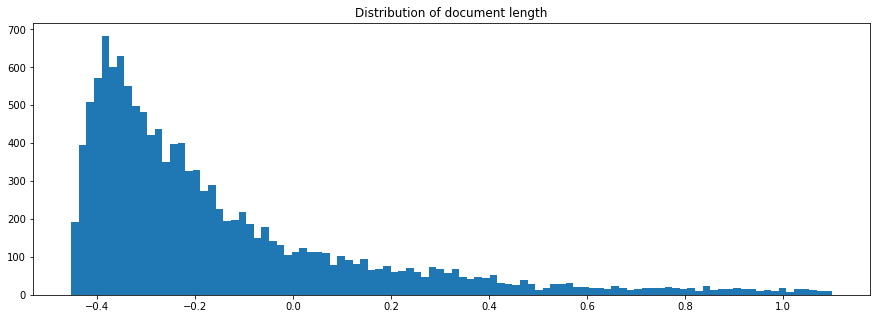

In [ ]:
lengths = list(train['char'])
lengths.sort()
plt.hist(lengths[:int(len(lengths)*0.95)], bins=100)
plt.title('Distribution of document length')
plt.show()

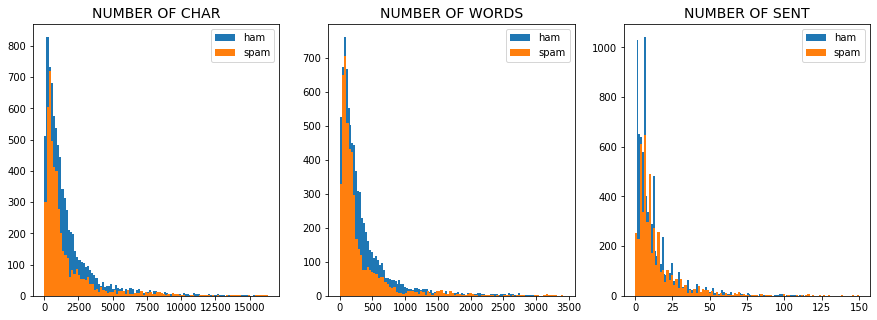

In [ ]:
perc = 0.99

plt.subplot(1, 3, 1)
lengths_0=list(train[train['Label']==0]['char'])
lengths_0.sort()
lengths_1=list(train[train['Label']==1]['char'])
lengths_1.sort()
plt.hist(lengths_0[:int(len(lengths_0)*perc)], bins=100, label='non-spam')
plt.hist(lengths_1[:int(len(lengths_1)*perc)], bins=100, label='spam')
plt.title('NUMBER OF CHAR', fontsize=14)
plt.legend(['ham','spam'])

plt.subplot(1, 3, 2)
lengths_0=list(train[train['Label']==0]['words'])
lengths_0.sort()
lengths_1=list(train[train['Label']==1]['words'])
lengths_1.sort()
plt.hist(lengths_0[:int(len(lengths_0)*perc)], bins=100, label='non-spam')
plt.hist(lengths_1[:int(len(lengths_1)*perc)], bins=100, label='spam')
plt.title('NUMBER OF WORDS', fontsize=14)
plt.legend(['ham','spam'])

plt.subplot(1, 3, 3)
lengths_0=list(train[train['Label']==0]['sent'])
lengths_0.sort()
lengths_1=list(train[train['Label']==1]['sent'])
lengths_1.sort()
plt.hist(lengths_0[:int(len(lengths_0)*perc)], bins=100, label='non-spam')
plt.hist(lengths_1[:int(len(lengths_1)*perc)], bins=100, label='spam')
plt.title('NUMBER OF SENT', fontsize=14)
plt.legend(['ham','spam'])
plt.show()

In [ ]:
# Check all the possible characters present in the documents

l = []
f = []
for d in tqdm(train['Body']):
  for c in str(d):
    if c in l:
      f[l.index(c)] = f[l.index(c)] + 1
    else:
      l.append(c)
      f.append(1)

# Here we order the char list based on the frequencies.
# We can't put the list in a dataFrame and use the sort_values function becouse some of the particular characters are not preserved in the transition

new_l = []
new_f = []
flag = 0

while flag == 0:
  index = f.index(max(f))

  new_l.append(l[index])
  new_f.append(f[index])

  l.pop(index)
  f.pop(index)

  if len(l)==0:
    flag=1

100%|██████████| 13253/13253 [00:31<00:00, 421.69it/s]


In [ ]:
def remove_link(text):
  count = len(re.findall(r'http\S+', text))
  text = re.sub(r'http\S+', '', text)
  count = count + len(re.findall(r"www.[A-Za-z]*\.com", text))
  text = re.sub(r"www.[A-Za-z]*\.com", "", text)
  return text, count>0

def remove_email(text):
  count = len(re.findall(r'\S+\@\S+\.\S+', text))
  text = re.sub(r'\S+\@\S+\.\S+', ' ', text)
  return text, count>0

def character_repeatation(text):
  Pattern_alpha = re.compile(r"([A-Za-z])\1{2,}", re.DOTALL)
  Formatted_text = Pattern_alpha.sub(r"\1\1", text) 
  Pattern_Punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
  Combined_Formatted = Pattern_Punct.sub(r'\1', Formatted_text)
  return Combined_Formatted

# def correct_me(text):
#   textBlb = TextBlob(text)        
#   textCorrected = textBlb.correct()
#   return textCorrected

def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  stripped_text = soup.get_text(separator=" ")
  return stripped_text

def lemmatizer(text):
  wordnet_lemmatizer = WordNetLemmatizer()
  lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
  return lemm_text

# def extract_lang(x, tokenized=True):
#   l = []
#   if tokenized==True:
#     x = " ".join(x)
#   _, _, _, detected_language = cld2.detect(str(x), returnVectors=True)
#   for lan in detected_language:
#     l.append(lan[2])
#   return l

# def extract_lang_count(x):
#   e = 0
#   o = 0
#   x = " ".join(x)
#   _, _, _, detected_language = cld2.detect(str(x), returnVectors=True)
#   for lan in detected_language:
#     if lan[2]=='ENGLISH':
#       e=e+lan[1]
#     else:
#       o=o+lan[1]
#   return(e,o)

def translate(x):
  if len(x)!=0:
    translator = Translator()
    translation = translator.translate(x, dest='en')
    output = translation.text
    diff=lev(x,output)/len(x)
  else:
    output=''
    diff=0
  return output, diff


In [ ]:
def clean_text(document, stemming=True):
  text = str(document)
  if len(text)>10000000:
    text = text[:10000000]


  #remove the whitespaces
  text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\r',' ').replace('\\', ' ')

  #convert the text in lower_case
  text = text.lower()

  #remove the emails adress
  text, email_removed = remove_email(text)

  #remove the links
  text, link_removed = remove_link(text)

  #remove accents
  text = unidecode(text)

  #remove the punctuation
  custom = list(string.punctuation)
  custom=custom+['\x08', '\x12', '\x1b', '\x18']
  
  temp = len(text)
  text="".join([i for i in text if i not in custom])
  if temp!=0:
    n_char_removed = (temp - len(text))/temp
  else:
    n_char_removed = 0

  #remove the numbers
  text = re.sub(r'\d', ' ', text)

  #remove the characters repetation
  text = character_repeatation(text)

  #remove html tags
  text = strip_html_tags(text)

  #Translation
  text, diff = translate(text)
  text = unidecode(text)
  text="".join([i for i in text if i not in custom])
  text = text.lower()
  text = re.sub(r'\d', ' ', text)

  #remove dobule/triple/... spaces
  text = re.sub(r'\s+', ' ', text)
  
  #TOKENIZATION
  token = text.split(' ')

  #STOP WORD REMOVAL
  stop_words = nltk.corpus.stopwords.words('english')
  stop = [i for i in token if i not in stop_words]

  #STEMMING
  if stemming == True:
    porter_stemmer = PorterStemmer()
    stem = [porter_stemmer.stem(i) for i in stop]
    res = stem
  else: #LEMMATIZATION
    lem = [lemmatizer(i) for i in stop]
    res = lem
  
  res = [i for i in res if i != '']
  res = [i for i in res if len(i) > 2]
  res = " ".join(res)
  return [res, link_removed, email_removed, n_char_removed, diff]

In [ ]:
tqdm.pandas()

train['clean_text'] = train['Body'].progress_apply(lambda x: clean_text(x))

train['link_removed'] = train['clean_text'].apply(lambda x: x[1])
train['email_removed'] = train['clean_text'].apply(lambda x: x[2])
train['n_char_removed'] = train['clean_text'].apply(lambda x: x[3])
train['lev_dist'] = train['clean_text'].apply(lambda x: x[4])
train['clean_text'] = train['clean_text'].apply(lambda x: x[0])

100%|██████████| 13253/13253 [21:21<00:00, 10.35it/s]


In [ ]:
l = []

for d in tqdm(train['clean_text']):
  for c in d:
    l.append(c)
l = list(set(l))

l

100%|██████████| 13253/13253 [00:02<00:00, 6103.08it/s]


['r',
 'b',
 'k',
 'e',
 'y',
 't',
 'x',
 'v',
 'm',
 'j',
 'h',
 'f',
 'd',
 'i',
 ' ',
 'g',
 'z',
 'q',
 'o',
 'n',
 'u',
 'c',
 'w',
 'p',
 'l',
 's',
 'a']

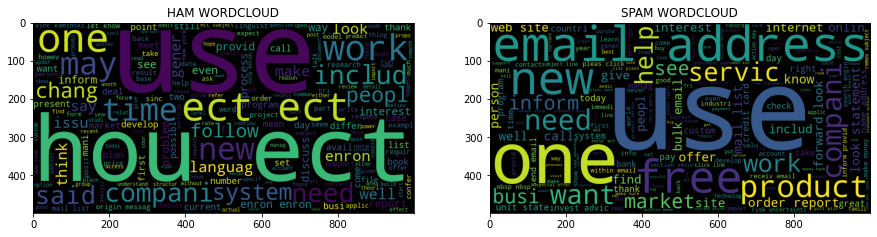

In [ ]:
spam_words = []
ham_words = []

for document in train[train['Label']==1]['clean_text']:
  for word in document.split(' '):
    spam_words.append(word)

for document in train[train['Label']==0]['clean_text']:
  for word in document.split(' '):
    ham_words.append(word)

wc1 = WordCloud(width=1000, height=500, min_font_size=10, background_color='black')
spam_wc = wc1.generate(" ".join(spam_words))

wc2 = WordCloud(width=1000, height=500, min_font_size=10, background_color='black')
ham_wc = wc2.generate(" ".join(ham_words))


plt.subplot(1,2,1)
plt.imshow(ham_wc)
plt.title('HAM WORDCLOUD')

plt.subplot(1,2,2)
plt.imshow(spam_wc)
plt.title('SPAM WORDCLOUD')
plt.show()

In [ ]:
# Create columns: char, words, sent (standardized)

train['char'] = train['Body'].apply(lambda x: len(str(x)))
train['words'] = train['Body'].apply(lambda x:len(nltk.word_tokenize(str(x))))
train['sent'] = train['Body'].apply(lambda x:len(nltk.sent_tokenize(str(x))))

mean_char = np.mean(train['char'])
mean_words = np.mean(train['words'])
mean_sent = np.mean(train['sent'])
mean_lev = np.mean(train['lev_dist']) 
mean_rem = np.mean(train['n_char_removed'])

std_char = np.std(train['char'])
std_words = np.std(train['words'])
std_sent = np.std(train['sent'])
std_lev = np.std(train['lev_dist']) 
std_rem = np.std(train['n_char_removed'])


train['char'] = train['char'].apply(lambda x: (x-mean_char)/std_char )
train['words'] = train['words'].apply(lambda x: (x-mean_words)/std_words )
train['sent'] = train['sent'].apply(lambda x: (x-mean_sent)/std_sent )
train['lev_dist'] = train['lev_dist'].apply(lambda x: (x-mean_lev)/std_lev )
train['n_char_removed'] = train['n_char_removed'].apply(lambda x: (x-mean_rem)/std_rem )

In [ ]:
train.reset_index(inplace=True, drop=True)

# **CLASSIFICATION**

## DOCUMENT REPRESENTATION

**TFIDF & PCA ON TRAIN SET**

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,1), min_df=30)
X = tfidf.fit_transform(train['clean_text']).toarray()
vocab = tfidf.get_feature_names_out()
X.shape

(13583, 4755)

In [ ]:
pca = PCA(n_components=500)
pca.fit(X)

PCA(n_components=500)

In [ ]:
principalComponents = pca.fit_transform(X)
principalComponents.shape

(13583, 500)

**TFIDF & PCA ON TEST SET**

In [ ]:
tqdm.pandas()

test['clean_text'] = test['Body'].progress_apply(lambda x: clean_text(x))

test['link_removed'] = test['clean_text'].apply(lambda x: x[1])
test['email_removed'] = test['clean_text'].apply(lambda x: x[2])
test['n_char_removed'] = test['clean_text'].apply(lambda x: x[3])
test['lev_dist'] = test['clean_text'].apply(lambda x: x[4])
test['clean_text'] = test['clean_text'].apply(lambda x: x[0])

100%|██████████| 4663/4663 [08:05<00:00,  9.61it/s]


In [ ]:
test['char'] = test['Body'].progress_apply(lambda x: len(str(x)))
test['words'] = test['Body'].progress_apply(lambda x: len(nltk.word_tokenize(str(x))) if len(x)<1000000 else len(x)/5 )
test['sent'] = test['Body'].progress_apply(lambda x:len(nltk.sent_tokenize(str(x))) if len(x)<1000000 else len(x)/40)

test['char'] = test['char'].apply(lambda x: (x-mean_char)/std_char )
test['words'] = test['words'].apply(lambda x: (x-mean_words)/std_words )
test['sent'] = test['sent'].apply(lambda x: (x-mean_sent)/std_sent )
test['lev_dist'] = test['lev_dist'].apply(lambda x: (x-mean_lev)/std_lev )
test['n_char_removed'] = test['n_char_removed'].apply(lambda x: (x-mean_rem)/std_rem )

100%|██████████| 4663/4663 [00:02<00:00, 2108.18it/s]


In [ ]:
tfidf_test = TfidfVectorizer(vocabulary=tfidf.vocabulary_)
X_test = tfidf_test.fit_transform(test['clean_text']).toarray()
vocab = tfidf_test.get_feature_names_out()
X_test.shape

In [ ]:
principalComponents_test = pca.fit_transform(X_test)

## DF PREPARATION 

In [ ]:
X_train = pd.DataFrame(principalComponents, columns = [ f'pc{_+1}' for _ in range(500) ])
X_train[['link_removed', 'email_removed', 'n_char_removed', 'lev_dist', 'char', 'words', 'sent', 'dataset']]=train[['link_removed', 'email_removed', 'n_char_removed', 'lev_dist', 'char', 'words', 'sent', 'dataset']]


In [ ]:
y_train = np.array(train['Label'])

In [ ]:
X_test = pd.DataFrame(principalComponents_test, columns = [ f'pc{_+1}' for _ in range(500) ])
X_test[['link_removed', 'email_removed', 'n_char_removed', 'lev_dist', 'char', 'words', 'sent', 'dataset']]=test[['link_removed', 'email_removed', 'n_char_removed', 'lev_dist', 'char', 'words', 'sent', 'dataset']]

In [ ]:
y_test = np.array(test['Label'])

##TEST

In [ ]:
X_train.drop(columns=['dataset'], inplace = True)

X_test['Label'] = y_test

X_test_assassin = X_test[X_test['dataset']=='assassin']
y_test_assassin = X_test_assassin['Label']
X_test_assassin.drop(columns=['dataset','Label'], inplace=True)

X_test_enron = X_test[X_test['dataset']=='enron']
y_test_enron = X_test_enron['Label']
X_test_enron.drop(columns=['dataset','Label'], inplace=True)

X_test_ling = X_test[X_test['dataset']=='ling']
y_test_ling = X_test_ling['Label']
X_test_ling.drop(columns=['dataset','Label'], inplace=True)


X_test.drop(columns=['dataset','Label'], inplace = True)

In [ ]:
clf = SVC(C=0.6, class_weight='balanced')

np.random.seed(123)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
cm_train = confusion_matrix(y_train, y_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                              display_labels=clf.classes_)


y_pred_test = clf.predict(X_test)
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                              display_labels=clf.classes_)

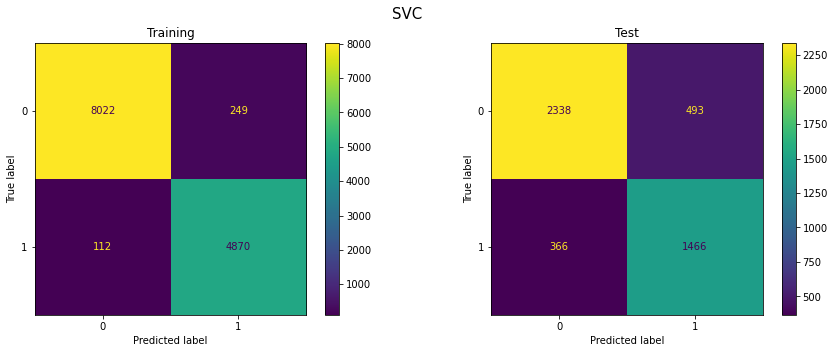

In [ ]:
fig = plt.figure()

fig.suptitle("SVC", fontsize=15)

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.title.set_text("Training")
ax2.title.set_text("Test")

disp_train.plot(ax=ax1)
disp_test.plot(ax=ax2)

plt.show()

In [ ]:
acc = round((cm_train[0][0]+cm_train[1][1])/(cm_train[0][0]+cm_train[0][1]+cm_train[1][0]+cm_train[1][1]),2)
precision = round((cm_train[1][1])/(cm_train[0][1]+cm_train[1][1]),2)
recall = round((cm_train[1][1])/(cm_train[1][0]+cm_train[1][1]),2)

print(f"TRAIN: accuracy:{acc}\t precision:{precision}\t recall:{recall}")

acc = round((cm_test[0][0]+cm_test[1][1])/(cm_test[0][0]+cm_test[0][1]+cm_test[1][0]+cm_test[1][1]),2)
precision = round((cm_test[1][1])/(cm_test[0][1]+cm_test[1][1]),2)
recall = round((cm_test[1][1])/(cm_test[1][0]+cm_test[1][1]),2)

print(f"TEST: accuracy:{acc}\t precision:{precision}\t recall:{recall}")

TRAIN: accuracy:0.97	 precision:0.95	 recall:0.98
TEST: accuracy:0.82	 precision:0.75	 recall:0.8


##### **OTHER CLASSIFIERS**

In [ ]:
clf = MLPClassifier(random_state=123, max_iter=1000)

np.random.seed(123)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
cm_train = confusion_matrix(y_train, y_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_pred),
                              display_labels=clf.classes_)


y_pred_test = clf.predict(X_test)
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_test),
                              display_labels=clf.classes_)

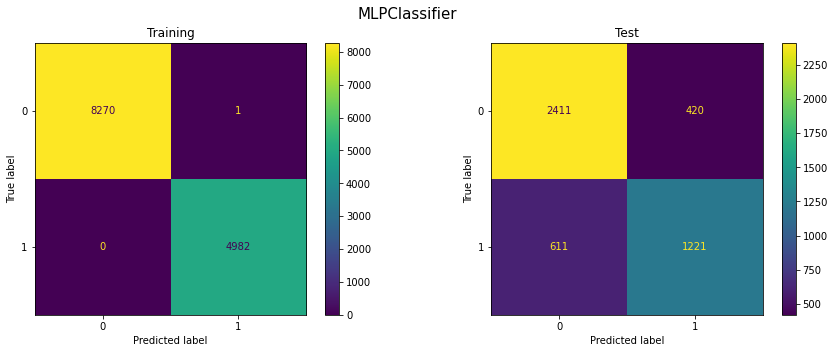

In [ ]:
fig = plt.figure()

fig.suptitle("MLPClassifier", fontsize=15)

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.title.set_text("Training")
ax2.title.set_text("Test")

disp_train.plot(ax=ax1)
disp_test.plot(ax=ax2)

plt.show()

In [ ]:
acc = round((cm_train[0][0]+cm_train[1][1])/(cm_train[0][0]+cm_train[0][1]+cm_train[1][0]+cm_train[1][1]),2)
precision = round((cm_train[1][1])/(cm_train[0][1]+cm_train[1][1]),2)
recall = round((cm_train[1][1])/(cm_train[1][0]+cm_train[1][1]),2)

print(f"TRAIN: accuracy:{acc}\t precision:{precision}\t recall:{recall}")

acc = round((cm_test[0][0]+cm_test[1][1])/(cm_test[0][0]+cm_test[0][1]+cm_test[1][0]+cm_test[1][1]),2)
precision = round((cm_test[1][1])/(cm_test[0][1]+cm_test[1][1]),2)
recall = round((cm_test[1][1])/(cm_test[1][0]+cm_test[1][1]),2)

print(f"TEST: accuracy:{acc}\t precision:{precision}\t recall:{recall}")

TRAIN: accuracy:1.0	 precision:1.0	 recall:1.0
TEST: accuracy:0.78	 precision:0.74	 recall:0.67


In [ ]:
clf = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=3, random_state=123)

np.random.seed(123)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
cm_train = confusion_matrix(y_train, y_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_pred),
                              display_labels=clf.classes_)


y_pred_test = clf.predict(X_test)
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_test),
                              display_labels=clf.classes_)

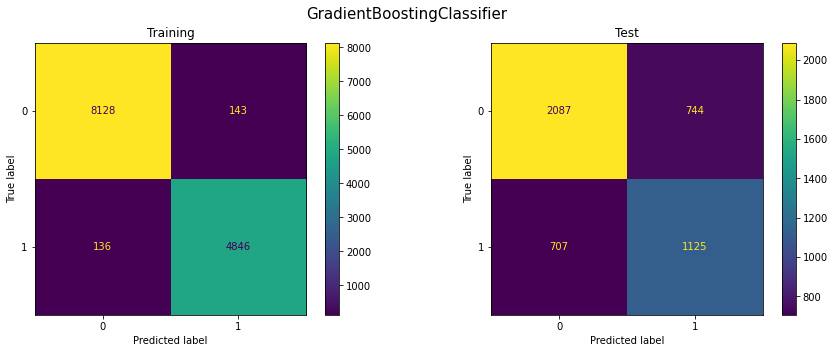

In [ ]:
fig = plt.figure()

fig.suptitle("GradientBoostingClassifier", fontsize=15)

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.title.set_text("Training")
ax2.title.set_text("Test")

disp_train.plot(ax=ax1)
disp_test.plot(ax=ax2)

plt.show()

In [ ]:
acc = round((cm_train[0][0]+cm_train[1][1])/(cm_train[0][0]+cm_train[0][1]+cm_train[1][0]+cm_train[1][1]),2)
precision = round((cm_train[1][1])/(cm_train[0][1]+cm_train[1][1]),2)
recall = round((cm_train[1][1])/(cm_train[1][0]+cm_train[1][1]),2)

print(f"TRAIN: accuracy:{acc}\t precision:{precision}\t recall:{recall}")

acc = round((cm_test[0][0]+cm_test[1][1])/(cm_test[0][0]+cm_test[0][1]+cm_test[1][0]+cm_test[1][1]),2)
precision = round((cm_test[1][1])/(cm_test[0][1]+cm_test[1][1]),2)
recall = round((cm_test[1][1])/(cm_test[1][0]+cm_test[1][1]),2)

print(f"TEST: accuracy:{acc}\t precision:{precision}\t recall:{recall}")

TRAIN: accuracy:0.98	 precision:0.97	 recall:0.97
TEST: accuracy:0.69	 precision:0.6	 recall:0.61


In [ ]:
clf = GaussianNB()

np.random.seed(123)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
cm_train = confusion_matrix(y_train, y_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_pred),
                              display_labels=clf.classes_)


y_pred_test = clf.predict(X_test)
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_test),
                              display_labels=clf.classes_)

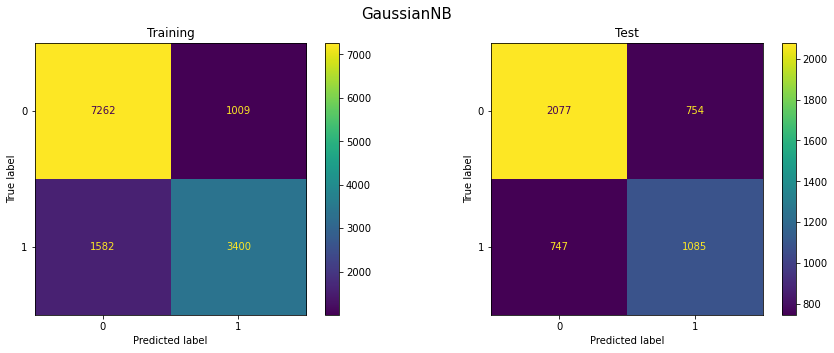

In [ ]:
fig = plt.figure()

fig.suptitle("GaussianNB", fontsize=15)

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.title.set_text("Training")
ax2.title.set_text("Test")

disp_train.plot(ax=ax1)
disp_test.plot(ax=ax2)

plt.show()

In [ ]:
acc = round((cm_train[0][0]+cm_train[1][1])/(cm_train[0][0]+cm_train[0][1]+cm_train[1][0]+cm_train[1][1]),2)
precision = round((cm_train[1][1])/(cm_train[0][1]+cm_train[1][1]),2)
recall = round((cm_train[1][1])/(cm_train[1][0]+cm_train[1][1]),2)

print(f"TRAIN: accuracy:{acc}\t precision:{precision}\t recall:{recall}")

acc = round((cm_test[0][0]+cm_test[1][1])/(cm_test[0][0]+cm_test[0][1]+cm_test[1][0]+cm_test[1][1]),2)
precision = round((cm_test[1][1])/(cm_test[0][1]+cm_test[1][1]),2)
recall = round((cm_test[1][1])/(cm_test[1][0]+cm_test[1][1]),2)

print(f"TEST: accuracy:{acc}\t precision:{precision}\t recall:{recall}")

TRAIN: accuracy:0.8	 precision:0.77	 recall:0.68
TEST: accuracy:0.68	 precision:0.59	 recall:0.59


# **TOPIC MODELING**

In [ ]:
X = pd.concat([train, test])

In [ ]:
X.head()

,Body,Label,dataset,char,words,sent,clean_text,link_removed,email_removed,n_char_removed,lev_dist
0,"\n \n lappin , shalom ( editor ) , ( school of...",0,ling,0.384223,0.354135,0.539786,lappin shalom editor school orient african stu...,False,False,-0.353043,-0.196818
1,75 % off for all new software . q 5 i\n get a ...,1,enron,-0.399414,-0.406605,-0.152391,new softwar get whop name ftware buy today sav...,False,False,0.434895,0.040113
2,\nNew Web Technology\nMortgage Rates Slashed F...,1,assassin,-0.169087,-0.258719,-0.238913,new web technolog mortgag rate slash last time...,False,False,-0.761105,-0.209384
3,"summer school on "" history of linguistics ""\n ...",0,ling,0.871316,0.872992,1.145441,summer school histori linguist swiss linguist ...,False,False,-0.266100,5.777089
4,april seminars ! ( houston )\n successful peop...,0,enron,-0.145268,-0.167229,-0.152391,april seminar houston success peopl take time ...,False,False,-0.347311,-0.220982


In [ ]:
tf_vectorizer = CountVectorizer(min_df=5, max_df=0.5)
dtm_tf = tf_vectorizer.fit_transform(X['clean_text'])
dtm_tf.shape

(18246, 21978)

In [ ]:
texts = list(X.clean_text.str.split())

In [ ]:
grid = {}
grid['Validation_Set'] = {}

min_topics = 2
max_topics = 12
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

model_results = {'Topics': [],
                 'Coherence': [],
                 'Perplexity': []
                }

pbar = tqdm(total=(len(topics_range)))

for k in topics_range:
  lda_tf = LatentDirichletAllocation(n_components=k, random_state=0, verbose=0, max_iter=10)
  lda_tf.fit(dtm_tf)

  cv = metric_coherence_gensim(measure='c_v', 
                        top_n=10, 
                        topic_word_distrib=lda_tf.components_, 
                        dtm=dtm_tf, 
                        vocab=np.array([x for x in tf_vectorizer.vocabulary_.keys()]), 
                        texts=texts,
                        return_mean=True)
  
  pv = lda_tf.perplexity(dtm_tf)
  
  model_results['Topics'].append(k)
  model_results['Coherence'].append(cv) 
  model_results['Perplexity'].append(pv)
  pbar.update(1)


In [ ]:
data = pd.DataFrame(model_results)

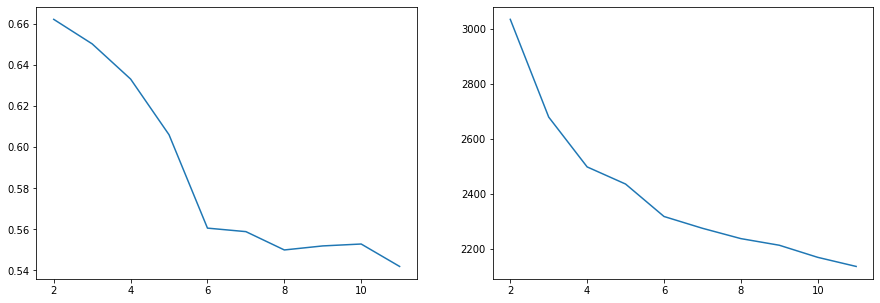

In [ ]:
plt.subplot(1,2,1)
plt.plot(data['Topics'], data['Coherence'])
plt.subplot(1,2,2)
plt.plot(data['Topics'], data['Perplexity'])
plt.show()

The best topic numerosity according to the coherence curve of the top 10 words per topic is 2, whilst perplexity suggests that the higher the number of topic the better. 3 is chosen as the number of topics in order to provide a bit more variety but still being recommended by coherence. High values of topics were rejected due to low coherence values and excessive lack of human interpretability.

In [ ]:
lda_tf = LatentDirichletAllocation(n_components=3, random_state=0, verbose=0, max_iter=10)
lda_tf.fit(dtm_tf)

LatentDirichletAllocation(n_components=3, random_state=0)

In [ ]:
vis = pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='tsne', R=10)
vis

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
1     -1015.700562  1338.981201       1        1  46.048519
2      -387.996002  -373.316162       2        1  29.111352
0     -2184.745605   -60.565800       3        1  24.840129, topic_info=           Term          Freq         Total Category  logprob  loglift
6839      enron  19185.000000  19185.000000  Default  10.0000  10.0000
6467        ect  11077.000000  11077.000000  Default   9.0000   9.0000
11349   languag   8139.000000   8139.000000  Default   8.0000   8.0000
20482   univers   6792.000000   6792.000000  Default   7.0000   7.0000
11731  linguist   5214.000000   5214.000000  Default   6.0000   6.0000
...         ...           ...           ...      ...      ...      ...
18805     studi   1665.403174   1840.823945   Topic3  -5.9743   1.2926
16535  research   2354.441156   3542.991923   Topic3  -5.6281   0.9840
10207    inform   2798.556258  10070.049636   Topic3  -5.4553   0.1122
14126       one   2457.537465  10199.863709   Topic3  -5.5852  -0.0305
20682       use   2422.970917  10954.140641   Topic3  -5.5994  -0.1160

[84 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
85         3  0.999825  abstract
301        1  0.984369  advertis
301        2  0.002537  advertis
301        3  0.013319  advertis
797        2  0.999616   analyst
...      ...       ...       ...
21626      3  0.999862  workshop
21652      1  0.399634     would
21652      2  0.430452     would
21652      3  0.169883     would
21866      1  0.998185      your

[152 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

We noticed that the ID (number) assigned to each topic is arbitrary and may vary upon a new execution of the code. Attemps to fix this random nature of the library was inconclusive. In case this section is recomputed, please keep in mind that commentary of one topic (say Topic 1) may now refer to another topic which contains the same words but has different ID.

In [ ]:
vis.topic_order

[2, 3, 1]

This topic_order means that <br>
**Topic1:** index 1 of LDA array (in variable m down below)<br>
**Topic2:** index 2 of LDA array (in variable m down below)<br>
**Topic3:** index 0 of LDA array (in variable m down below)<br>




In [ ]:
m = lda_tf.transform(dtm_tf)

In [ ]:
proba = []
for _ in m:
  proba.append(_)

X['proba'] = proba
X['topic'] = X['proba'].apply(lambda x: np.argmax(x))

In [ ]:
print(f"percentage of topic1 coming from assassin dataset:\t {round(len(X[(X['dataset']=='assassin') & (X['topic']==1)]) / len(X[(X['topic']==1)]),2)*100}%")
print(f"percentage of topic2 coming from enron dataset:\t\t {round(len(X[(X['dataset']=='enron') & (X['topic']==2)]) / len(X[(X['topic']==2)]),2)*100}%")
print(f"percentage of topic3 coming from ling dataset:\t\t {round(len(X[(X['dataset']=='ling') & (X['topic']==0)]) / len(X[(X['topic']==0)]),2)*100}%")

percentage of topic1 coming from assassin dataset:	 50.0%
percentage of topic2 coming from enron dataset:		 98.0%
percentage of topic3 coming from ling dataset:		 73.0%


* The first topic is equally correlated with enron and assassin Datasets
* The second topic is strongly correlated with enron Dataset
* The third topic is correlated with ling Datasets

## SEPARATE TOPIC EXTRACTION BETWEEN SPAM AND HAM


In [ ]:
spam = X[X['Label']==1]
ham = X[X['Label']==0]

#### **HAM**

In [ ]:
tf_vectorizer = CountVectorizer(min_df=5, max_df=0.5)
dtm_tf = tf_vectorizer.fit_transform(ham['clean_text'])
dtm_tf.shape

lda_tf = LatentDirichletAllocation(n_components=3, random_state=0, verbose=0, max_iter=10)
lda_tf.fit(dtm_tf)

LatentDirichletAllocation(n_components=3, random_state=0)

In [ ]:
vis = pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='tsne', R=10)
vis

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
2     -1015.700562  1338.981201       1        1  41.366272
1      -387.996002  -373.316162       2        1  29.549218
0     -2184.745605   -60.565800       3        1  29.084510, topic_info=          Term          Freq         Total Category  logprob  loglift
4164     enron  19118.000000  19118.000000  Default  10.0000  10.0000
3926       ect  10948.000000  10948.000000  Default   9.0000   9.0000
7345   languag   8063.000000   8063.000000  Default   8.0000   8.0000
13820  univers   6648.000000   6648.000000  Default   7.0000   7.0000
6109       hou   5249.000000   5249.000000  Default   6.0000   6.0000
...        ...           ...           ...      ...      ...      ...
12652  subject   3728.683745   4877.894674   Topic3  -4.9050   0.9663
4135    energi   2606.451933   3213.165318   Topic3  -5.2631   1.0257
13133    thank   2893.578705   3756.211756   Topic3  -5.1586   0.9740
9978     pleas   4033.425933   6147.441044   Topic3  -4.8264   0.8135
14636    would   2852.793651   7215.397835   Topic3  -5.1728   0.3070

[84 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
51         2  0.999791  abstract
1272       1  0.970038   billion
1272       3  0.029644   billion
2392       2  0.999562    cognit
2450       1  0.002247       com
...      ...       ...       ...
14636      3  0.395404     would
14660      1  0.975673     wrote
14660      2  0.001133     wrote
14660      3  0.023230     wrote
14774      1  0.998684      your

[148 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [ ]:
vis.topic_order

[3, 2, 1]

This topic_order means that <br>
**Topic1:** index 2 of LDA array (in variable m down below)<br>
**Topic2:** index 1 of LDA array (in variable m down below)<br>
**Topic3:** index 0 of LDA array (in variable m down below)<br>

In [ ]:
m = lda_tf.transform(dtm_tf)

proba = []
for _ in m:
  proba.append(_)

ham['proba'] = proba
ham['topic'] = ham['proba'].apply(lambda x: np.argmax(x))

print(f"percentage of topic1 coming from assassin dataset:\t {round(len(ham[(ham['dataset']=='assassin') & (ham['topic']==2)]) / len(ham[(ham['topic']==2)]),2)*100}%")
print(f"percentage of topic2 coming from ling dataset:\t\t {round(len(ham[(ham['dataset']=='ling') & (ham['topic']==1)]) / len(ham[(ham['topic']==1)]),2)*100}%")
print(f"percentage of topic3 coming from enron dataset:\t\t {round(len(ham[(ham['dataset']=='enron') & (ham['topic']==0)]) / len(ham[(ham['topic']==0)]),2)*100}%")

percentage of topic1 coming from assassin dataset:	 90.0%
percentage of topic2 coming from ling dataset:		 85.0%
percentage of topic3 coming from enron dataset:		 99.0%


#### **SPAM**

In [ ]:
tf_vectorizer = CountVectorizer(min_df=5, max_df=0.5)
dtm_tf = tf_vectorizer.fit_transform(spam['clean_text'])
dtm_tf.shape

lda_tf = LatentDirichletAllocation(n_components=3, random_state=0, verbose=0, max_iter=10)
lda_tf.fit(dtm_tf)

LatentDirichletAllocation(n_components=3, random_state=0)

In [ ]:
vis = pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='tsne', R=10)
vis

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
2     -1015.700562  1338.981201       1        1  48.845858
1      -387.996002  -373.316162       2        1  27.965186
0     -2184.745605   -60.565800       3        1  23.188956, topic_info=           Term         Freq        Total Category  logprob  loglift
8732     report  4072.000000  4072.000000  Default  10.0000  10.0000
9753  statement  2132.000000  2132.000000  Default   9.0000   9.0000
2565    compani  5110.000000  5110.000000  Default   8.0000   8.0000
2379      click  3093.000000  3093.000000  Default   7.0000   7.0000
5937     invest  2425.000000  2425.000000  Default   6.0000   6.0000
...         ...          ...          ...      ...      ...      ...
9167      secur  1204.012951  2619.354061   Topic3  -5.1241   0.6842
2565    compani  1638.503215  5110.913014   Topic3  -4.8159   0.3239
7024      money  1204.625096  3753.883863   Topic3  -5.1235   0.3249
1767       busi  1029.703412  3889.970520   Topic3  -5.2804   0.1324
5790     inform  1038.719976  4249.253649   Topic3  -5.2717   0.0527

[94 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
76         1  0.246490  account
76         2  0.062331  account
76         3  0.691304  account
108        3  0.996174  acrobat
139        1  0.781538  address
...      ...       ...      ...
11154      1  0.202801   within
11154      2  0.723673   within
11154      3  0.073659   within
11239      2  0.997744    wysak
11272      3  0.990399      yap

[179 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [ ]:
vis.topic_order

[3, 2, 1]

This topic_order means that <br>
**Topic1:** index 2 of LDA array (in variable m down below)<br>
**Topic2:** index 1 of LDA array (in variable m down below)<br>
**Topic3:** index 0 of LDA array (in variable m down below)<br>

In [ ]:
m = lda_tf.transform(dtm_tf)

proba = []
for _ in m:
  proba.append(_)

spam['proba'] = proba
spam['topic'] = spam['proba'].apply(lambda x: np.argmax(x))

print(f"percentage of topic1 coming from enron dataset:\t\t {round(len(spam[(spam['dataset']=='enron') & (spam['topic']==2)]) / len(spam[(spam['topic']==2)]),2)*100}%")
print(f"percentage of topic2 coming from assassin dataset:\t {round(len(spam[(spam['dataset']=='assassin') & (spam['topic']==1)]) / len(spam[(spam['topic']==1)]),2)*100}%")
print(f"percentage of topic3 coming from enron dataset:\t\t {round(len(spam[(spam['dataset']=='enron') & (spam['topic']==0)]) / len(spam[(spam['topic']==0)]),2)*100}%")

percentage of topic1 coming from enron dataset:		 67.0%
percentage of topic2 coming from assassin dataset:	 25.0%
percentage of topic3 coming from enron dataset:		 88.0%
